What's up! It's been a long time since the last post, i'm quite lazy recently, but from know i will try to write more blog post though. I've revisited the Titanic dataset, this time through the lens of ensemble learning techniques. Previously I wrote about this dataset in this [blog](https://buidai123.github.io/blog/posts/titanic_competition/), but now, let's dive into why random forests and gradient boosting machine are particularly suitable for tabular data.

You might ask, "Why not just use logistic regression?" While it seems simple, logistic regression can be surprisingly difficult to get right especially with transformation, interactions, and outlier handling. Random forests, on the other hand, offers resilience and robustness that are hard to match, which I'll explain today.

To start, building a random forest is insightful help demystify the intricacies of machine learning algorithm. I'll also touch on bagging and boosting, giving a clear view of their strengths

On a practical note, a helpful tip I've stumbled upon is using fastai's import to efficiently bringing in essential libraries like Numpy an pandas. Here's the snippet to simplify your setup:

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

These tools and techniques have enhanced my learning journey, and I'm excited to share these insights with you. Alright without any further ado let's get right into it.

## Decision Tree

### Data Processing

First off, ensure that you have the Titanic dataset downloaded, Here's the quick setup:

In [2]:
import zipfile, kaggle

path = Path('titanic')
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

100%|██████████| 34.1k/34.1k [00:00<00:00, 365kB/s]

I've previously detailed the intricacies of processing the Titanic dataset in a separate blog post which you might find useful. For now, let's breeze through some basic data processing steps without going into too much detail:

In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

Our next task involves organizing the data by identifying continuous and categorical variables, along with dependent variable we're predicting

In [4]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

Now, a brief look at how `Pandas` handles categorical variables. Let's consider the `Sex` column:

In [5]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

It's fascinating, although it appears unchanged(still just `Male` and `Female`), it's now a category with a predefine list. Behind the magic, Pandas cleverly assigns numerical codes for these categories for efficient processing:

In [6]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

It's actually turned them into numbers. This transformation sets the stage for our decision tree modeling

### Binary Split

A random forest is essentially an ensemble of decision trees, and each tree is constructed from a series of binary split. But what exactly is a binary split?

Imagine taking all the passengers on the Titanic and dividing them into males and females to examine their survival rates.

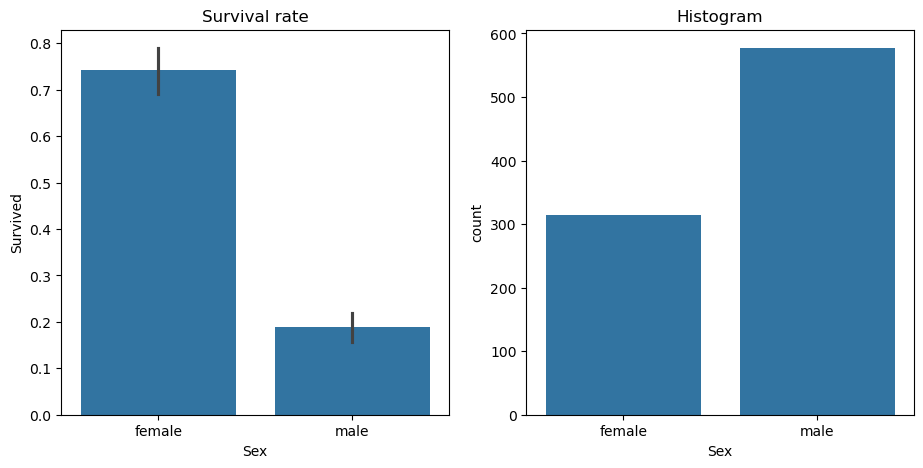

In [7]:
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

we see a stark difference: about a 20% survival rate for males and 75% for females, there are roughly twice as many males as females. If you base a model solely on sex, predicting survival becomes surprisingly effective: men likely didn't survive, while who man likely did this division by sex exemplifies a binary split - it simple divide the data into two distinct groups.

To test the efficacy of this basic model, we first split our data into training and test dataset and encode our categorical variables.

In [8]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

Next, let's create function to to extract independent variables (`xs`) and the dependent variable (`y`).

In [9]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

From here we make predictions:

In [10]:
from sklearn.metrics import mean_absolute_error
preds = val_xs.Sex==0
mean_absolute_error(val_y, preds)

0.21524663677130046

A 21.5% error rate isn't too shabby for such a simple model. Can we do better? Let's try another variable such as `Fare` which is continuous.

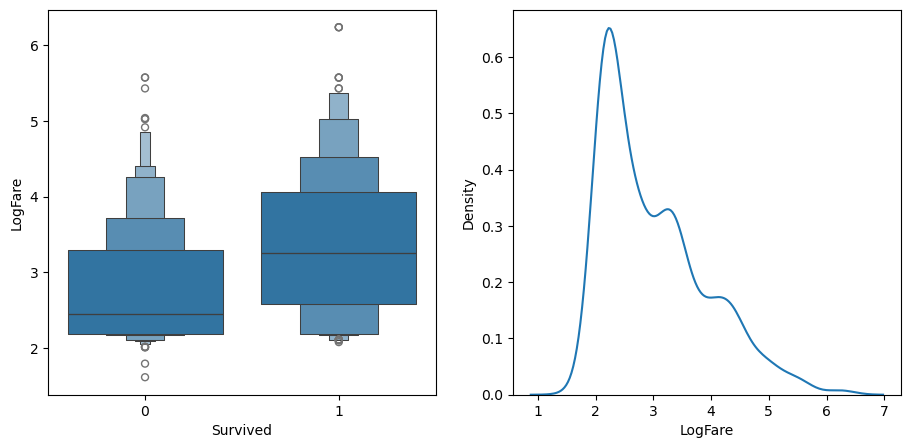

In [11]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

The boxenplot shows that those who survived generally paid higher fares. 

So here's another model `LogFare` greater than 2.7:

In [12]:
preds = val_xs.LogFare>2.7
mean_absolute_error(val_y, preds)

0.336322869955157

Oh, much worse

To evaluate binary split uniformly, regardless of the datatype, We measure how similar the dependent variable values are within each split. We aim for standard deviations within groups, multiplied by group sizes to account for impact differences.

In [13]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

So for example, if we split by Sex, is greater than or less than 0.5.That'll create two groups, males and females, and that gives us this score.

In [14]:
score(trn_xs["Sex"], trn_y, 0.5)

0.4078753098206398

And if we do LogFare greater than or less than 2.7, it gives us this score.

In [15]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.4718087395209973

Lower scores indicates better splits, with `Sex` outperforming `LogFare`. But how can we find a best split point i mean we have to try ourself right? In every values and see if the score improve or not right, well that was pretty inefficient. It would be nice if we could find some automatic wway to do al that. Well, of course we can. If we want to find the best split point for `Age`, and try each one in turn, and see what score we get, if we made a binary split on that level of `Age`. So here's a list of all the possible binary split threshold of `Age`

In [16]:
col = trn_xs["Age"]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

Let's go through all of them. For each of them calculate the score and then `Numpy` and `Pytorch` have an `argmin()` function, which tells you what index into that list is the smallest.

In [17]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

Here's the scores.

In [18]:
scores

array([0.48447755, 0.48351588, 0.48158676, 0.48061929, 0.47964987, 0.480937  , 0.48347294, 0.48171397, 0.47987776, 0.47884826,
       0.47831672, 0.47949847, 0.47957573, 0.48092137, 0.48130659, 0.48200571, 0.48163287, 0.48124801, 0.48151498, 0.48183316,
       0.48105614, 0.48202484, 0.48178211, 0.48337829, 0.48439618, 0.48501782, 0.48545475, 0.48556795, 0.48550856, 0.48554074,
       0.48550094, 0.48504976, 0.48480161, 0.48561331, 0.4852559 , 0.48513473, 0.48529147, 0.48530156, 0.48543741, 0.48569729,
       0.48571309, 0.48571467, 0.4856701 , 0.48563657, 0.48579877, 0.48579767, 0.4858019 , 0.48580095, 0.48580002, 0.48580178,
       0.48580211, 0.48579777, 0.4857996 , 0.48580236, 0.48579236, 0.48580043, 0.48580303, 0.4858034 , 0.4857613 , 0.4855666 ,
       0.48579394, 0.48580506, 0.48580434, 0.48580707, 0.48579364, 0.48580788, 0.48581017, 0.48580597, 0.48581077, 0.48576815,
       0.48580167, 0.48545792, 0.48567909, 0.48542059, 0.48557468, 0.48492654, 0.4852198 , 0.48548666, 0.485902

Create a function to calculate this for any column:

In [19]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.47831671750899085)

Revealing that is at 6.0 for `Age`. So now we can just go through and calculates the score for the best split point for each column.

In [20]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.4078753098206398),
 'Embarked': (0, 0.478833425731479),
 'Age': (6.0, 0.47831671750899085),
 'SibSp': (4, 0.4783740258817423),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736595),
 'Pclass': (2, 0.4604826188580666)}

And if we do that, we find that the lowest score is Sex. So that is how to calculate the  best binary split. So we now know that the model we created earlier with `Sex` is the best single binary split model we can find.

And this simple thing we just did which is finding a single binary split, actually is a type of model, it has a name too, it's called OneR. And OneR model it turned out in a review of machine learning methods in the 90s is one of the best, if not the best. It's not a bad idea to always start creating a baseline of OneR, a decision tree with a single binary split.

### Creating a Tree

"OneR" is probably not going to cut it for a lot of things, though it's surprisingly effective, but maybe we could go a step further. And the other step further we could go is by creating a maybe "TwoR". What if we took each of those groups, males and females in the Titanic dataset, and split each of these into two other groups? So split the males into two groups and split the females into two groups. To do that, we can repeat the exact same piece of code we just did, but let's remove sex from it:

In [21]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

Then, run the same piece of code that we just did before, but just for the males:

In [22]:
{o:min_col(males, o) for o in cols}

{'Embarked': (0, 0.387558187041091),
 'Age': (6.0, 0.37398283710105873),
 'SibSp': (4, 0.38758642275862637),
 'Parch': (0, 0.3874704821461953),
 'LogFare': (2.803360380906535, 0.38048562317581447),
 'Pclass': (1, 0.3815544200436083)}

This provides a "OneR" rule for how to predict which males survived the Titanic, Interestingly, age turns out to be the biggest predictor for males whether they were greater than or less than 6 determined their survival odds

Similarity, for females:

In [23]:
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857326),
 'Age': (50.0, 0.4225927658431646),
 'SibSp': (4, 0.42319212059713585),
 'Parch': (3, 0.4193314500446157),
 'LogFare': (4.256321678298823, 0.413505983329114),
 'Pclass': (2, 0.3335388911567602)}

The passenger class `Pclass`, or whether they were in first class or not, was the biggest predictor of survival.

This process generates a decision tree - a serries of binary splits that gradually categorize our data so that in the leaf nodes, we derive strong predictions about survival

We can continue these steps for each of the four groups manually with a couple of extra lines of code, or we can use a decision tree classifier. This class automates the process we just outlined:

In [24]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

And one very nice thing it has is it can draw the tree for us. So here's a tiny little draw_tree function:

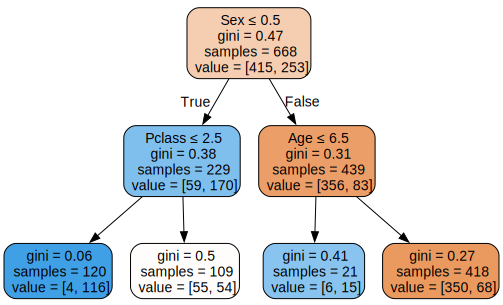

In [25]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, trn_xs, size=10)

And you can see here it's going to first of all split on sex. Now, it looks a bit weird to say sex is less than or equal to 0.5, but remember our binary characteristics are coded as zero or one. This is just an easy way to denote males versus females.

For females, the next split is based on their class. For males, age is the dedicating factor. This creates our four leaf nodes. For instance, of the females in the first class, 116 survived, and only 4 didn't showing that being a wealthy woman on the Titanic was quite advantageous. On the other hand, among adult males, 68 survived while 350 perished, illustrating the peril they faced.

This quick summary showcases why decision trees are favoured in exploratory data analysis; they provide a clear picture of key variables driving the dataset and their predictive power

One additional point is the `Gini` measure, a way of evaluating how good a split is, which i've illustrated in the code below:

In [26]:
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

To understand this mathematically: if $p$ is a probability of an instance being classified as a positive class, and $(1 - p)$ for the negative class, $p^2$ denotes the chance of both randomly selected instances being positive and $(1-p)^2$ being negative. The term $(1-p^2 - (1-p)^2)$ gives us the probability of misclassification, subtracting the chances of correctly classifying instances.

Here's an example of `Gini` calculation for gender:

In [27]:
gini(df.Sex=='female'), gini(df.Sex=='male')

(0.3828350034484158, 0.3064437162277842)

Here, `act.mean()**2` is the probability that two randomly selected individual both survived, and `(1 - act.mean())**2` that both did not. Lower `Gini` impurity suggests a strong skew in survival outcomes, which can be insightful for decision making or predicting survival likelihood based on gender.

Decision trees thus provide not only visual insights but quantitative ways to discern what's happening within your dataset.

In [28]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

So that was for the "OneR" version. For the decision tree with four leaf nodes, the mean absolute error was 0.224, which is actually a bit worse. This outcome suggest that due to the small size of the dataset, the "OneR" method was impressively effective, and enhancements weren't substantial enough to be discerned among the randomness of such a small validation set.

To take it further, let's implement a decision tree with a minimum of 50 samples per leaf node:

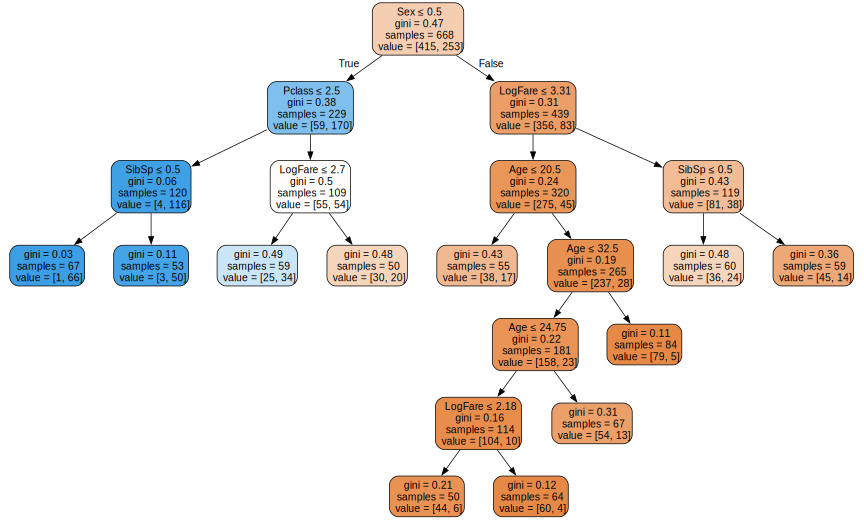

In [29]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

This indicates that each leaf will contain at least 50 samples, in this context passengers on the Titanic. For example, suppose you've identified that 67 people were female, first-class, and under 28. That's the point where the tree ceases splitting further

Let's evaluate this decision tree:

In [30]:
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

With an absolute error of 0.183, this approach shows a bit of improvement.

An interesting aspect of decision trees is the minimal preprocessing required you may have noticed this advantage. There was no need for dummy variables for category features, and although you can create them, it isn't necessary. Decision trees can manage without these adjustments. We only took the logarithm of the fare to enhance the visual appearance of our graph but the split would operate identically on the original scale, focusing only on data ordering

Moreover, decision trees are indifferent to outliers, long-tailed distributions, and categorical variables: they handle all these situations effectively.

The take away here is that for tabular data, starting with a decision tree-based approach is prudent. It helps create baselines because they are remarkably resilient and offer a robust performance without intricate tuning

## Random Forest

Now, what if we wanted to make this more accurate? Could we grow the tree further? We could, but with only 50 samples in these leaves, further splitting would result in the leaf nodes having so little data that their predictions wouldn't be very meaningful. Naturally, there are limitation to how accurate a decision tree can be. so, what we can do? Enter a fascinating strategy called [bagging](https://www.stat.berkeley.edu/~breiman/bagging.pdf).

Here's the procedure of bagging:

1. Randomly choose a subset of data rows (a "bootstrap replicate" of the learning set).
2. Train a model using this subset.
3. Save that model, then go back to step 1 and repeat several times.
4. This will give you multiple trained models. Predict with all models, and then average their predictions to make the final prediction.

The core insight of bagging is that although models trained on data subsets will make more errors than a model trained  on the full dataset, these errors aren't correlated across models. Different models will make different errors, and when averaged, those errors offset each other. Thus, average the predictions of all the model sharpens the final prediction with more models providing finer estimations.

In essence, a random forest averages the predictions of numerous decision trees, which are generated randomly varying parameters such as training dataset or tree parameters. Bagging is a particular approach to "ensembling" or combining results from multiple models.

Let's create one in a few lines. Here's a function to generate a decision tree:

In [31]:
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

Here, `prop` denotes the data proportion used, say 75% each time with `n` as the sample size. Random samples `idxs` are selected based on the specified proportion, and a decision tree is built from this subset.

Let's get 100 trees and compile them into a list:

In [32]:
trees = [get_tree() for t in range(100)]
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

0.2272645739910314

By collecting predictions from these trees, stacking them, and averaging their predictions, we have our random forest.

Random forests are remarkably simple yet powerful. A key feature is that they also randomly select subset of columns to build decision trees, changing the column subset with each node split. The idea is to maintain randomness, yet retain usefulness. For more efficient implementation, we use `RandomForestClassifier`:

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

Here, we specify the number of trees and samples per leaf, then fit the classifier. While our mean absolute error might not surpass a single decision tree due to dataset constraints, it remains robust

One can inspect the built decision trees to identify split columns. Monitoring column improvements in `Gini` across decision trees yields a **feature importance plot**:

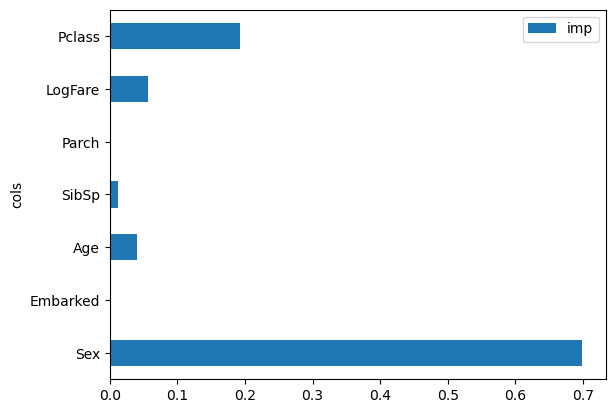

In [34]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

Feature importance plots demonstrate a feature's significance by indicating how frequently and effectively it was used for splits. The `Sex` variable emerges as most significant, follow by `Pclass`, with other variables less crucial. And this is another reason, by the way, why the random forest isn't really particularly helpful, because it's just a easy split to do, basically all the matter is what class you are in and whether you're male of female.

Random Forests, due to their versatility with data distribution and categorical variable handling, allow immediate and insightful datasets analyses. For large datasets, they quickly reveal key features, facilitating further focused analysis.

## What else can we do with Random Forest

There are other things that you can do with Random Forests and the Titanic dataset is a small one, so it doesn't highlight the full power of Random Forests. For a bigger and more numerically interesting dataset, let's consider the auction price of heavy industrial equipment. This dataset is from The [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/overview) Kaggle competition. I highly recommended taking a peek at the overview and the dataset on the competition page before we start.

### Preparing Stuff

#### Downloading the Dataset

In [ ]:
#| code-fold: true
#| code-summary: "Import stuff click to show the code"

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

import warnings
warnings.simplefilter('ignore', FutureWarning)

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
#| echo: false
warnings.filterwarnings("ignore", message="X has feature names, but DecisionTreeRegressor was fitted without feature names")
warnings.filterwarnings("ignore", message="X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names")
warnings.filterwarnings("ignore", message="The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.")


Pick a path to download the dataset:

In [37]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers')

Use the Kaggle API to download the data to the specified path and extract it:

In [38]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 48.4M/48.4M [00:07<00:00, 6.52MB/s]


(#7) [Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers/Machine_Appendix.csv'),Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers/Test.csv'),Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.csv'),Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers/Valid.csv'),Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers/ValidSolution.csv'),Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers/median_benchmark.csv'),Path('/home/monarch/.fastai/archive/bluebook-for-bulldozers/random_forest_benchmark_test.csv')]

I'll now walk you through the dataset. If you examine the [Data tab](https://www.kaggle.com/c/bluebook-for-bulldozers/data) on the competition page, here are the key fields found in train.csv:

- `SalesID`: The unique identifier of the sale.
- `MachineID`: the unique identifier of the machine. A machine can be sold multiple times.
- `saleprice`: The auction sale price of the machine (only provided in train.csv)
- `saledate`: The date the sale occurred.

We begin by reading the training set into Pandas `DataFrame`. It's generally advisable to specify `low_memory=False` unless Pandas runs out of memory and throws an error. By default, `low_memory` is `True`, instructing Pandas to process data in chucks, which may lead to inconsistent column data types and subsequent data processing or modeling errors.

In [39]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

That's many columns to scour! Start by exploring the dataset to familiarize yourself with the data content in each column. Soon we'll focus on the most compelling bits.

With ordinal columns, it's beneficial to specify meaningful order. These columns contain strings with an inherent sequence. For example, check out the `ProducSize` levels:

In [40]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

Instruct Pandas about the relevant order of these levels:

In [41]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In this dataset, Kaggle suggests using Root Mean Square Log Error (RMSLE) as the metric for comparing actual versus predicted auction prices.

In [42]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

This transformation ensures that the target variables is in format suitable for modeling.

#### Data Preparation

The first piece of data preparation we need to to do is enrich our representation of dates. The fundamental basis of the decision tree that we just discussed is bisection (dividing a group into two). We look at the ordinal variables and divide the dataset based on whether the variable's value is greater (ow lower) than a threshold, and we look at the categorical variables and divide the dataset based on whether the variable's level is a particular level. This algorithm divides the dataset based on both original and categorical data

But how does this apply to a common data type, the date? You might want to tree at date as an ordinal value because it is meaningful to say that one date is greater than other. However, dates are a bit different from most ordinal values in that some dates are qualitatively different from others, which is often relevant to the systems we are modeling.

To help our algorithm handle dates intelligently, we'd like our model to know ore than whether a date is more recent or less recent than other. We might want our model to make decisions based on that date's day of the week, on whether a day is holiday, on what month it is in, and so forth. To accomplish this, we replace every date column with a set of date metadata columns, such as holiday, day of the week, and month. These columns provide categorical data that we suspect will be useful.

Fastai comes with a function to do this for us that mean we only need to pass in a column name that contains dates:

In [43]:
df = add_datepart(df, 'saledate')

# do the same for the test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

We can see that there are now many new columns in our `DataFrame`:

In [44]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

This a solid first step, but we need further data cleaning. For this, we will use fastai objects called `TabularPandas` and `TabularProc`.

Another aspect of preparatory processing is ensuring we can handle strings and missing data. We will use fastai's class `TabularPandas`, which wraps a Pandas `DataFrame` and offers some conveniences. when we say it "wraps" a `DataFrame`, it means taking a Pandas `DataFrame` as input and adding additional specifically useful for machine-learning tasks with tabular data. To populate a `TabularPandas`, we will utilize two `TabularProcs`: `Categorify` and `FillMissing`.

`TabularProcs` are unique data transformation process used in fastai designed to prepare you data to ML models. We introduce two specific `TabularProcs` here:

- `Categorify`: convert categorical columns text or non numeric data into numeric categories. For instance, a column `Color` with values like "Red", "Blue", "Green" could be encoded as 1, 2, 3.
- `FillMissing`: Manages missing data in your dataset. it replaces missing values with the column's median value and creates a new boolean column to flag rows that originally had missing values.

How `TabularProc` differs from regular transforms:

- Returns the exact same object that's passed to it, after modifying the object in place, which optimizes memory efficiency especially with large datasets.
- Executes the transformation immediately when the data is first passed in rather than delaying until the data is accessed.

In practical terms, when using `TabularPandas` with `TabularProcs`:

1. Start with your raw data in a Pandas `DataFrame`.
2. Wrap this `DataFrame` with `TabularPandas`.
3. Apply `TabularProcs` (`Categorify` and `FillMissing`)
4. These procs instantly process all your data, converting categories to numbers and filling in missing values.
5. The outcome is a dataset ready for machine learning models, with all categorical data converted and missing values addressed.

This methodology streamlines the data preparation process, ensure consistent data processing ready for model training or inference.

In [45]:
procs = [Categorify, FillMissing]

`TabularPandas` will also manage the dataset split into training and validation sets for us.

#### Handling a Time Series

When dealing with time series data, randomly selecting a subset of data points for training and validation is not sufficient, as sequence of data is vital. The test set represents a future six-month period starting from May 2012, thus not overlapping with the training set. This setup is intentional because the competition sponsor aims to evaluate the model's predictive capability selected from a later time than your training dataset.

The provided Kaggle training data concludes in April 2012. Therefore, we'll construct to focused training dataset comprising data from before November 2011 and establish a validation set with data from after November 2011.

This is achieved using `np.where`, which helps in obtaining indices for specific conditions:

In [46]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

TabularPandas requires knowledge of which columns are continuous and which are categorical. We can simplify this with the `cont_cat_split` helper function:

In [47]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

This setup turns `TabularPandas`into something akin to a fastai `Dataset` object, with accessible train and valid attributes:

In [48]:
len(to.train),len(to.valid)

(404710, 7988)

It's possible to view the dataset's categorical variables still represented as strings:

In [ ]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


However, all underlying data has been converted to numeric form:

In [50]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


Categorical columns undergo transformation by substituting each unique category with a number. These numbers are assigned consecutively as they first appear, implying no intrinsic value to these numbers, unless ordered categories (like `ProductSize`) pre-specify the sequence. You can check the mapping through the classes attribute:

In [51]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

A neat feature in fastai is the ability to save processed data, which can be time-consuming. Saving the data allows you to resume further work without repeating the preprocessing steps. Fastai utilizes Python's pickle system for this purpose:

In [52]:
save_pickle(path/'to.pkl',to)

to retrieve it later you'll simply do:

In [53]:
to = load_pickle(path/'to.pkl')

With preprocessing complete, we're set to create a decision tree.

### Decision Tree Ensembles

Let's consider how we find the right questions to ask when creating decision trees. Fortunately we don't have to do this manually computer are designed for this purpose! Here's a simple overview of training a decision tree:


1. Loop through each column of the dataset in turn.
2. For each column, loop through each possible level of that column in turn.
3. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
4. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
5. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
6. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
7. Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.

To implement this, start by defining your independent and dependent variables:

In [54]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [ ]:
xs.head()

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleDay,saleDayofweek,saleDayofyear,saleElapsed
0,2,963,298,43,...,16,3,320,1.163635e+09
1,2,1745,529,57,...,26,4,86,1.080259e+09
2,1,336,111,0,...,26,3,57,1.077754e+09
3,1,3716,1381,0,...,19,3,139,1.305763e+09
4,3,4261,1538,0,...,23,3,204,1.248307e+09


Once your data is numeric and lacks missing values, you can create a decision tree:

In [56]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

Here, we've instructed sklearn to create four leaf nodes. To visualize what the model has learned, we can display the tree:

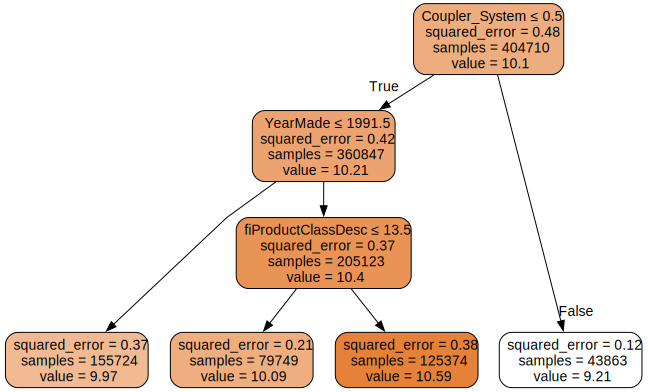

In [57]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

Understanding this visualization helps in graphing decision tree:

1. Top node: Represents the entire dataset before any splits. Average sale price (log) is 10.10, with a mean squared error of 0.48.

2. First split: Based on coupler_system.

- Left branch: coupler_system < 0.5 (360,847 records, avg. 10.21)
- Right branch: coupler_system > 0.5 (43,863 records, avg. 9.21)

3. Second split (on left branch): Based on `YearMade`.

- Left sub-branch: `YearMade` <= 1991.5 (155,724 records, avg. 9.97)
- Right sub-branch: `YearMade` > 1991.5 (205,123 records, avg. 10.4)

4. Leaf nodes: The bottom row, where no more splits occur.

We can display this information using Terence Parr's dtreeviz library to enhance visualization:

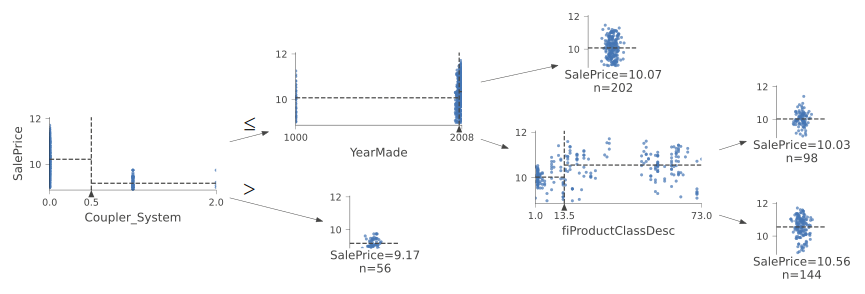

In [58]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

This visualization illuminates data distribution, showcasing issues like bulldozers dated to the year 1000, likely placeholders for missing data. For modeling precision, these can be substituted with 1950 to improve visualization clarity without significantly influencing model results:

In [59]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

This update clarifies the tree visualization while maintaining the models integrity. After making this change, re-evaluate the decision tree:

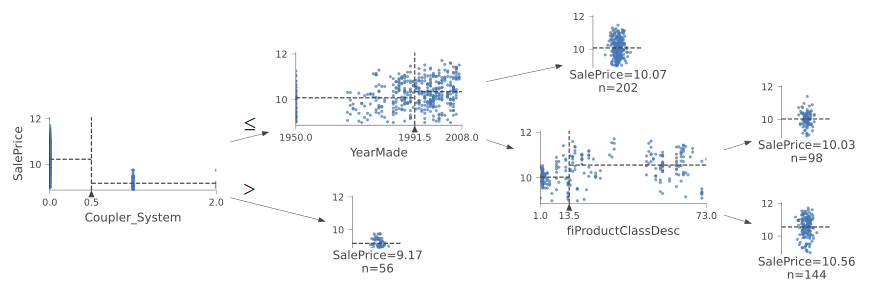

In [60]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Now, let's leverage the decision tree algorithm to generate a more complex model. This time, we'll refrain from specifying any stopping criteria, such as `max_leaf_nodes`:

In [61]:
m = DecisionTreeRegressor()
m.fit(xs, y);

To evaluate our model's performance, we'll define a function to compute the root mean squared error(RMSE) which was the scoring criterion in this competition:

In [62]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
m_rmse(m, xs, y)

0.0

The output is 0.0. At the first glance, it appears that our model is flawless. But hold on, we need to evalueate the validation set to check for overfitting:

In [63]:
m_rmse(m, valid_xs, valid_y)

0.332239

The validation set RMSE is 0.332239, indicating potential overfitting. Let's investigating further

In [ ]:
m.get_n_leaves(), len(xs)

(324338, 404710)

It turns out our model has nearly as many leaves as data point! This occurs because sklearn's default setting allow continual splitting until there's just one item per leaf node. We can address this by adjusting the stopping rule to require each leaf node to have at least 25 auction records:

In [65]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.243049, 0.308857)

This results in a more balanced model. Let's verify the new number of leaves:

In [66]:
m.get_n_leaves()

12432

Decision trees are adept at modelling data due to their adaptability to nonlinear relationships and variable interactions. Nonetheless, a compromise exist between generallizability (achieved with smaller trees) and training accuracy (achieved with larger trees)

How do wee balance these strengths? We'll explore further after covering essential aspect handling categorical variables.

In deep learning, categorical variables are often one-hot encoded and fed into embedding layers. However, decision trees lack embedding layers so how can we leverage untreated categorical variables efficiently? let's consider a use-case with product codes.

Suppose we have an auction dataset with product codes (categorical variables) and sale prices. "Product X" for instance, consistently sells at a premium. Decision trees split data based on features optimally partition the target variable. A split distinguishing "Product X" from others creates:

- Group A: containing product X
- Group B: containing all other products

This chose arises because "Product X" is notably pricier, leading Group A to have a higher average price than Group B. This split provides valuable insights for price prediction, prompting the algorithm to prefer it. The decision tree isolates "Product X" quickly, allowing precise price predictions while evaluating other products' prices.

One-hot encoding is another option; it transforms a single categorical column into multiple binary columns, each representing a category level. Pandas offers the `get_dummies` method which does just that.

However, there's little evidence that one-hot encoding enhances results. Thus, we tend to avoid it when unnecessary, as it complicates data handling.

### Creating a Random Forest

Creating a random forest involves a process similar to crafting a decision tree, but with added flexibility through parameters that determine the number of trees, data point subset size(rows), and field subset size(columns):

In [67]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

Here's an explanation of the parameters used in the function:

- `n_estimators`: specifies the number of tree in the forest.
- `max_samples`: indicates how many rows to sample when training each tree.
- `max_features`: sets the number of columns to sample at each split (e.g., 0.5 means using half of the columns).
- `min_samples_leaf`: determines the minimum number of samples required in the leaf node, controlling the tree depth.

Additionally, `n_jobs=-1` ensures that all available CPUs are utilized for parallel tree building. This function allows quick experimentation with different configurations.

Initiating the random forest model is straightforward:

In [68]:
m = rf(xs, y);

By using multiple trees rather than a single `DecisionTreeRegressor`, the validation RMSE significantly improves:

In [69]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171371, 0.233223)

A distinctive feature of random forests is the resilience hyperparameter configurations, particularly `max_features`. 

:::{.callout-note}
When we say random forests show resilience to hyperparameter configurations, it means that the algorithm performs well across a range of different hyperparameter settings. It doesn’t require very precise tuning to achieve good results, making it a flexible option in many applications.
:::

The N_estimators parameter can be set to as high as value as feasible, the more trees, the greater the accuracy potential

For visualizing effects of varying max_features with increasing tree counts, refer to sklearn's documentation which provides insightful plots.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png">

The image demonstrates:

- Blue line: represents minimal features usage.
- Green line: represents maximal feature usage (full feature set). Subsets of features combined with numerous trees usualy yield the lowest error.

To explore the impact of `n_estimators` analyze predictions from each individual tree within the forest (accessible via the `estimators_` attribute):

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
r_mse(preds.mean(0), valid_y)

0.233223

This calculation, `preds.mean(0)`, parallels the overall random forest prediction. Observe RMSE progression as trees are added:

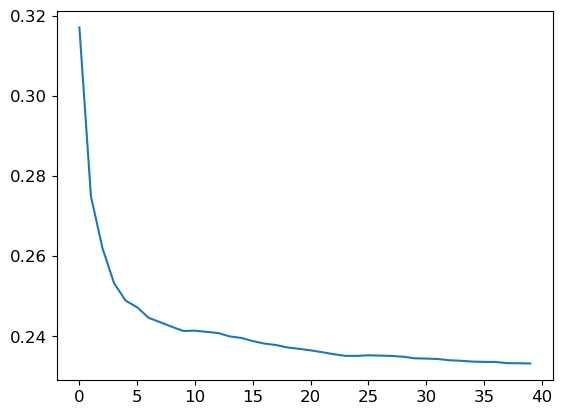

In [72]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

Despite improved RMSE in training, the validation set's performance may deteriorate due to potential overfitting or time discrepancies. This challenge is addressable by leveraging the out-of-bag (OOB) error methodology in random forests, offering valuable insights.

In the next section, we'll delve deeper into creating a random forest and optimizing it's performance.

### Out of Bag Error

In a random forest, each tree is trained on different subset of data. Consequently, there's a unique opportunity: each tree has an implicit validation set composed of the data rows not selected for its training, know as out-of-bag (OOB) data.

OOB error is particularly useful when dealing with a limited dataset, as it offers a measure of model generalization without needing to withhold data for a separate validation set. These OOB predictions are stored in the `oob_prediction_` attribute. Remember, these are compared with training labels, as the OOB calculation involves the training set:

In [73]:
r_mse(m.oob_prediction_, y)

0.211234

The OOB error frequently appears lower than the validation set error, hinting that other factors might contribute to the validation error, hinting that other factors might contribute to the validation error outside mere generalization discrepancies. We'll delve into these causes soon.

### Model Interpretation

Interpreting models trained on tabular data presents valuable insights. Higher understanding can be sought in ares like:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

Random forests are adept at addressing these questions. Let's start with evaluating confidence in predictions!

Model predictions are an average of individual tree predictions, providing an estimated value. But how can we gauge the confidence of this estimate? One simplistic approach is using the standard deviations of tree predictions - higher deviations imply less confidence, suggesting that caution is needed, especially in scenarios where tree predictions are inconsistent.

In creating the random forest, predictions over the validations set were obtained using Python's list comprehension:

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
preds.shape

(40, 7988)

This results in a prediction for each tree across all validation set auctions (40 trees, 7,988 auctions). With this data, compute the standard deviation of predictions for each auction:

In [76]:
preds_std = preds.std(0)
preds_std[:5]

array([0.2000169 , 0.08355874, 0.113672  , 0.2747    , 0.12065141])

The standard deviations highlight varying levels of confidence across auctions. A lower deviation signals stronger agreement among trees, leading to higher confidence. Conversely, higher deviations indicate disagreement, pointing towards lower confidence. In practical applications like auction bidding, this information is useful; you might reconsider bidding when predictions show low certainty.

#### Feature Importance

Knowing a model's predictive accuracy is critical, but equally important is understanding how those predictions are made. Feature importance offers valuable insight into this process. Sklearn's random forest model provides feature importance scores via the `feature_importance_` attributes. Here's a simple function load these scores into a DataFrame and sort them

In [77]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.166375
30,Coupler_System,0.113599
6,ProductSize,0.103802
7,fiProductClassDesc,0.078686
3,fiSecondaryDesc,0.054542
54,ModelID,0.052919
65,saleElapsed,0.050521
31,Grouser_Tracks,0.041514
12,Enclosure,0.039451
32,Hydraulics_Flow,0.035355


Evaluating the features importances reveals that a few columns significantly contribute to the model's predictions, most notably, `YearMade` and `ProductSize`.

To visualize these importance, plotting them can clarify their relative value:

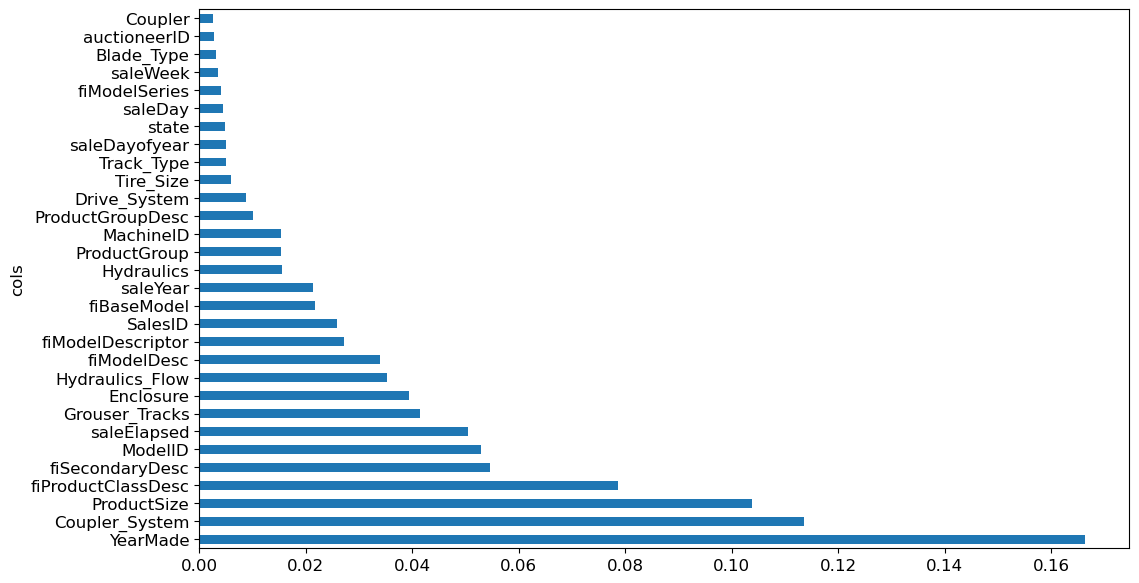

In [78]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

#### Removing Low-Importance Variables

A subset of columns might suffice to maintain accuracy while enhancing simplicity by discarding low-importance variables. Let's retain only those with an importance score above 0.005:

In [79]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

22

Retrain the model using this refined feature set:

In [80]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.180965, 0.231633)

The models accuracy remain consistent, yet fewer columns necessitate examination:

In [81]:
len(xs.columns), len(xs_imp.columns)

(66, 22)

Simplifying a model is often the initial step in enhancing it having 78 columns can be overwhelming for deep analysis. Particularly, a learner, more interpretable model is simpler to deploy and manage.

Revisiting the feature importance plot provides clearer insights:

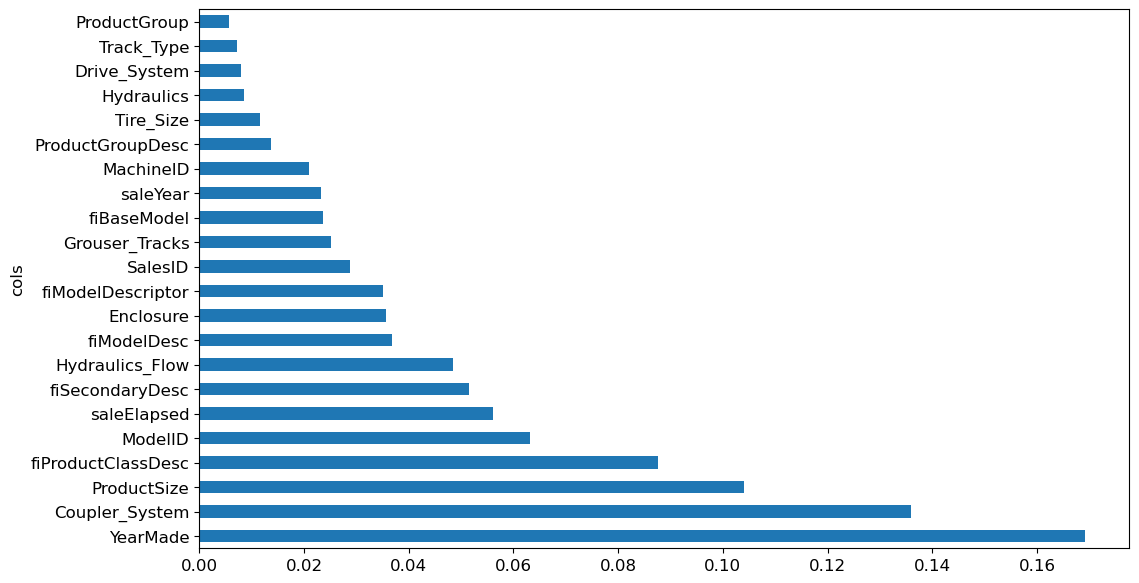

In [82]:
plot_fi(rf_feat_importance(m, xs_imp));

While interpreting, redundancy may arise as seen with `ProductGroup` and `ProductGroupDesc`. Attempting to remove such redundant features can further streamline interpretation.

#### Removing Redundant Variables

We'll begin by clustering columns to identify pairs that are closely aligned often suggesting redundancy:

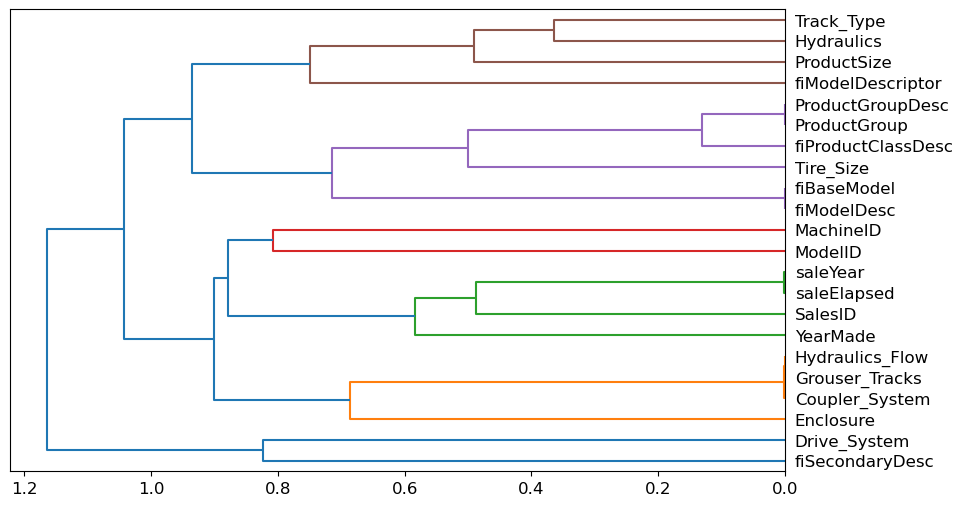

In [83]:
cluster_columns(xs_imp)

The chart generated from clustering will reveal which columns were merged early on. Notably, pairs like `ProductGroup` with `ProductGroupDesc`, `saleYear` with `saleElapsed`, and `fiModelDesc` with `fiBaseModel` are likely correlated to the point of redundancy.

Next, we will attempt to simplify the model by removing these related features. We begin by defining a function to quickly train a random forest and capture the out-of-bag(OOB) score. This score, ranging from 1.0 for perfection to near-zero, provides a relative comparison metric as we remove redundant columns:

In [84]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

First, we'll confirm our baseline score with all columns:

In [85]:
get_oob(xs_imp)

0.8760739540611289

Next, test the impact of removing each potentially redundant variable individually:

In [86]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8742959821922331,
 'saleElapsed': 0.8698149904307536,
 'ProductGroupDesc': 0.8755334280543031,
 'ProductGroup': 0.8745495772129529,
 'fiModelDesc': 0.8743458666758965,
 'fiBaseModel': 0.8748827464781819,
 'Hydraulics_Flow': 0.8762012623754625,
 'Grouser_Tracks': 0.8755826405754699,
 'Coupler_System': 0.8758570604637711}

We'll also explore the effect of dropping one columns from each identified pair:

In [87]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8743053306321846

Encouragingly, the model's performance remains largely unchanged. We will now finalize this reduce dataset:

In [88]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

For later retrieval, you can load these condensed datasets with:

In [89]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

Let's verify that the RMSE remains consistent after this reduction:

In [90]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.182663, 0.231313)

By concentrating on key variables and eliminating redundancies, we've streamlined our model significantly. Now, let's further explore how these influential variables affect predictions using partial dependence plots.

#### Partial Dependence

Alright, let's get a feel for these predictions. Imagine checking out the menu at a restaurant. Before ordering, you'd want to know what's popular, right? We do the same thing with our data. For `ProductSize`, we count how many times each size appears using something like Pandas' `value_counts` method and then plot this on a bar chart. Here's our code in action:

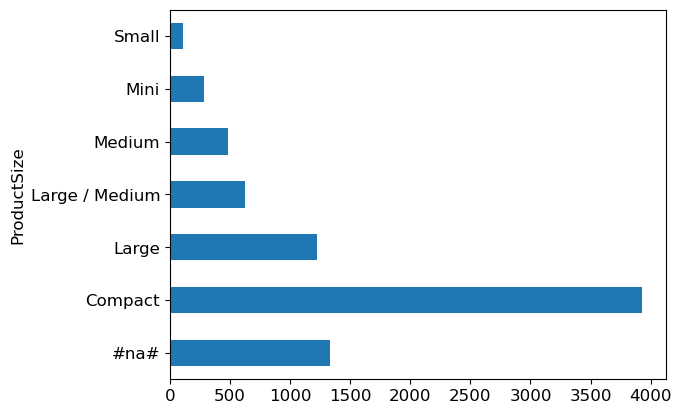

In [91]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

Turns out, the biggest "dish" on our menu is labeled `Compact` but look at #na#, fastai's way of showing missing values. No big surprise there!

What about YearMade? This time, instead of a bar chart, we whip out a histogram.

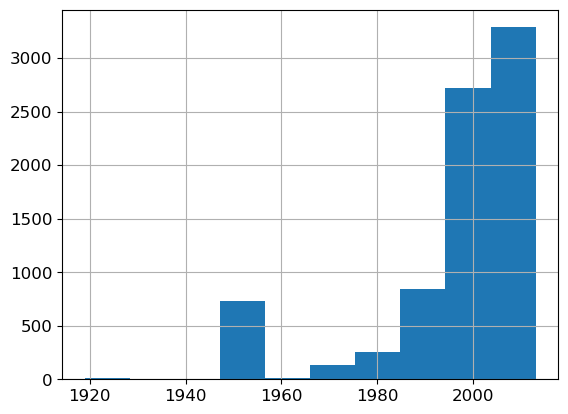

In [92]:
ax = valid_xs_final['YearMade'].hist()

Apart from 1950, which we used as placeholder for unknown years, most machines were crafted post-1990. Vintage anyone?

Partial dependence plots help us see what would happen to the sale price if one feature changed while everything else stayed the same.

For YearMade, we can't just average sale prices by year because many things change over time. Instead, we replace every year value with a single year, like 1950, and calculate the average predicted sale price. We repeat this for each year, up to 2011, to see how YearMade alone affects price.

Then, we plot the results:

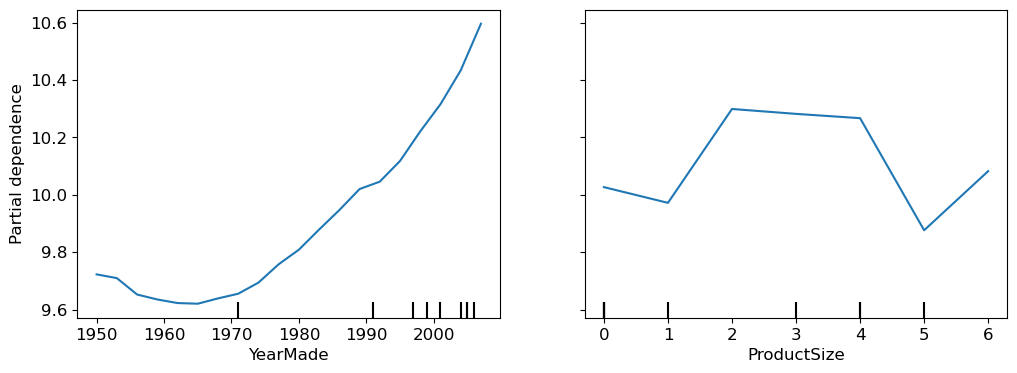

In [93]:
from sklearn.inspection import PartialDependenceDisplay
fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade', 'ProductSize'],
                                        grid_resolution=20, ax=ax)

For YearMade, after 1990, there's a clear pattern: prices rise as the year increase. This make sense because older items depreciate.

The plot for ProductSize show that the group with missing values has the lowest prices. Understanding why these values are missing is crucial, as sometimes they can be good predictors, or they could indicate an issue like data leakage

#### Data Leakage

In the world of data mining, there’s a tricky issue known as data leakage, described in detail by Shachar Kaufman, Saharon Rosset, and Claudia Perlich in their paper, [Leakage in Data Mining: Formulation, Detection, and Avoidance.](https://dl.acm.org/doi/10.1145/2020408.2020496) They define it as the unintentional introduction of information about the target of a data mining problem that shouldn't be available to mine from. To put it simply, it’s like saying ‘it rains on rainy days,’ where the model mistakenly uses the target itself as an input.

Data leakage can be subtle, appearing in various forms, and one such form is through missing values. Here are the straightforward steps to spot data leakage:

- Assess whether your model's accuracy seems too perfect. If it feels too good to be true, leakage might be playing a part.
- Evaluate the significant predictors. If they don’t add up in a practical sense, then something might be off.
- Analyze the partial dependence plots. If they yield nonsensical results, you could be facing a leakage issue.

Additionally, tools like tree interpreters can aid in understanding which factors are influencing specific predictions.

Avoiding data leakage demands meticulous attention through all phases of data handling—from collection to preparation. The key is adopting a "learn-now, predict-later" approach, ensuring that models are built without any preview of the answers.

#### Tree Interpreter

Before we go in please make sure you're already have `treeinterpreter` and `waterfallcharts` installed if not run this in your terminal
```bash
pip install treeinterpreter
pip install waterfallcharts
```

At the start of this section, we said that we wanted to be able to answer five questions:

:::{.callout-note}
- How confident are we in our predictions using particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that predictions?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purpose of prediction?
- How do predictions vary, as we vary these columns?
:::

We've addressed four of these, leaving only the second question. To tackle this, we'll use the `treeinterpreter` library, along with the `waterfallcharts` library for visualization.

In [94]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

While we've computed feature importances across entire random forest, we can apply a similar concept to a single row of data. This approach examines the contribution of each variable to improving the model at each branch of every tree, then sums these contributions per variables for a specific data point.

For example, if we're analyzing a particular auction item predicted to be expensive, we can understand why by examining that single row of data. We'll process it through each decision tree, observing the split used at each point and calculating the increase or decrease in addition compared to the parent node. This process is repeated for every tree, summing up the total change in importance by split variable.

:::{.callout-note}
For example, if you're predicting house prices:

- The bias might be the average house price in your dataset.
- A positive contribution from the "number of bedrooms" feature would indicate that having more bedrooms increased the predicted price.
- A negative contribution from the "distance from city center" feature might indicate that being further from the city center decreased the predicted price.
:::

Let's select the first few rows of our validation set:

In [95]:
row = valid_xs_final.iloc[:5]

We can then use `treeinterpreter`:

In [96]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

Here, `prediction` is the random forest's prediction, `bias` is the prediction based on the mean of the dependent variable, and `contributions` shows how each feature (independent variable) in your input data contributed to moving the prediction away from the bias. The sum of `contributions` plus `bias` equals the `prediction` for each row

In [97]:
prediction[0], bias[0], contributions[0].sum()

(array([10.06313964]), 10.104746057831763, -0.04160642242374439)

To visualize the contributions clearly, we can use waterfall plot:

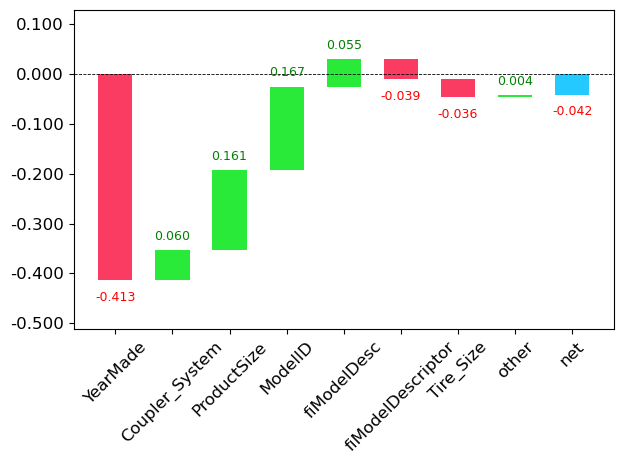

In [98]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');

This plot demonstrates how positive and negative contributes from all independent variables sum up to create the final prediction, show in the rightmost column labeled `net`.

This type of information is particularly valuable in production environments, rather than during model development. It can provide users of your data product with insightful information about the underlying reasoning behind the predictions.

Having explored these classic machine learning techniques, we're now ready to see how deep learning can contribute to solving this problem

## Extrapolation and Neuron Networks

Random forests, like all machine learning or deep learning algorithms, don't always generalize well to new data. Lets explore this issue, particularly focusing on the extrapolation problem that random forests face.

### The Extrapolation Problem

Consider a simple task: making prediction from 40 data points showing a slightly noisy linear relationship. We'll create this data and visualize it:

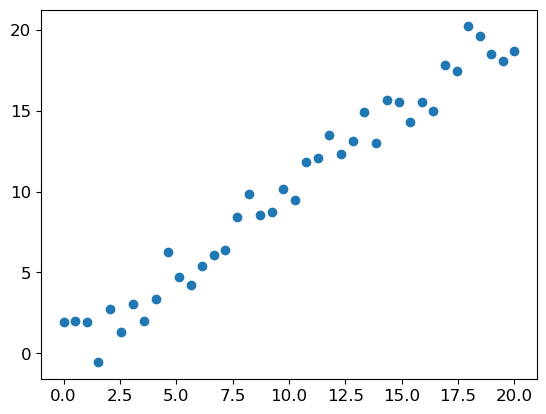

In [99]:
np.random.seed(42)
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

We need to reshape our data for sklearn, which expect a matrix of independent variables:

In [100]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [101]:
x_lin[:,None].shape

torch.Size([40, 1])

Now, let's create a random forest using the first 30 rows for training:

In [102]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

We'll test the model on the full dataset and visualize the results:

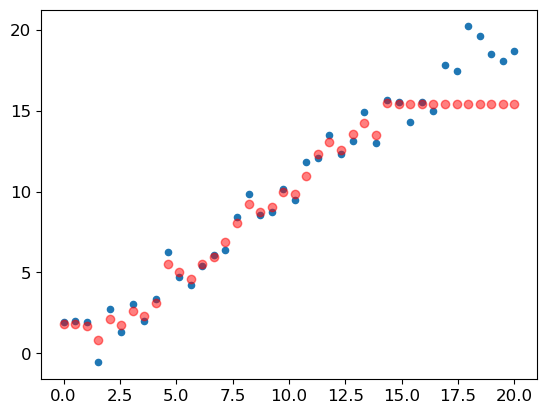

In [103]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

Here's where we encounter a significant issue: our predictions outside the training data domain are consistently too low. This happens because a random forest average value of the rows in a leaf. Consequently, a random forest can't predict values outside the rage of its training data.

This limitation is particularly problematic for data with time-based trends, like inflation, where future predictions are needed. Your predictions will systematically be too low.

The problem isn't limited to time variables, though. Random forest struggle to extrapolate beyond the types of data they've seen in a more general sense. That's wy it's crucial to ensure our validation set doesn't contain out-of-domain data

### Finding Out-of-Domain Data

Identifying whether your test set is distributed differently from your training data can be challenging. Interestingly, we can use a random forest to help us with this task. Here's how:

Instead of predicting our actual dependent variable, we'll try to predict whether a row belongs to the validation set or the training set. Let's combine our training and validation sets, create a new dependent variable representing the dataset origin, and build a random forest:

In [104]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.910266
11,SalesID,0.073707
14,MachineID,0.012246
0,YearMade,0.000813
9,fiModelDesc,0.000535
5,ModelID,0.000471


This reveals three columns that differ significantly between the sets: `saleElapsed`, `SalesID` and `MachineID`. `saleElapsed` directly encoded the date, while `SalesID` and `MachineID` likely represent incrementing identifiers over time.

Let's compare the RMSE of our original model with versions that exclude these columns:

In [105]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231001
SalesID 0.230214
saleElapsed 0.235865
MachineID 0.231447


It appears that we can remove SalesID and MachineID without losing accuracy:

In [106]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228264

Removing these variables slightly improves the model's accuracy and should make it more resilient over time, easier to maintain, and understand.

Sometimes, using only recent data can help. Let's try using data from the most recent years:

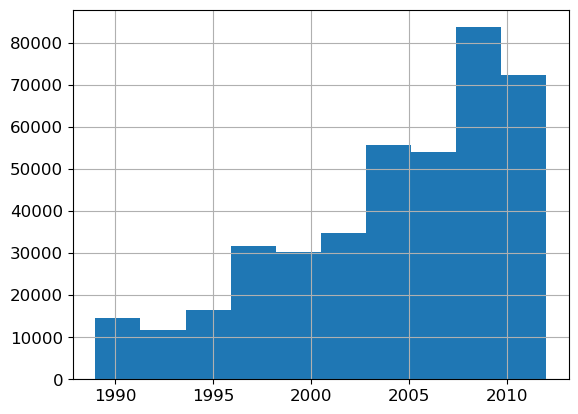

In [107]:
xs['saleYear'].hist();

In [108]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]


m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176448, 0.228537)

This yields a slightly improvement, demonstrating that using your entire dataset isn't always the best approach; sometimes subset can perform better.

I recommend building a model with `is_valid` as the dependent variable for all datasets. This can uncover subtle domain shift issues that might otherwise go unnoticed.

Next, we'll explore whether using a neural network can further improve our results

### Using Neural Networks

To build a neural network model, we'll follow a similar approach to our random forest setup. First, let's replicate the steps for creating the TabularPandas object:

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

We can utilize the column selection from our random forest model for the neural network:

In [110]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Neural networks handle categorical columns differently than decision trees. Embedding are an effective method for categorical variables in neural nets. Fastai determines which columns should be treated as categorical by comparing the number of distinct levels to the `max_card` parameter. We'll use 9,000 as our `max_card` to avoid unnecessarily large embeddings:

In [111]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

It's crucial to ensure that `saleElapsed` isn't treated as a categorical variable as we need to predict auction sale prices in the feature. Let's verify the continuous variable

:::{.callout-note}
As a continuous variable, `saleElapsed` can capture trends over time. If it were treated as a categorical variable, you'd lose the ability to interpolate or extrapolate between known values, which is crucial for prediction.

When you're predicting auction sale prices for future dates, you'll be dealing with 'saleElapsed' values that weren't in your training data. If 'saleElapsed' were categorical, your model wouldn't know how to handle these new values.
:::

In [112]:
cont_nn

['saleElapsed']

Now, let's examine the cardinality of our chosen categorical variables:

In [113]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
fiSecondaryDesc        177
ModelID               5281
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
fiModelDescriptor      140
Hydraulics              12
ProductGroup             6
Drive_System             4
Tire_Size               17
Track_Type               2
dtype: int64

We notice two "model" variables with similar high cardinalities, suggesting potential redundancy. To reduce the embedding matrix size. Let's assess the impact of removing one of these model columns on our random forest:

In [114]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.178386, 0.229505)

given the minimal impact, We'll remove `fiModelDescriptor` from our neural network predictors:

In [115]:
cat_nn.remove('fiModelDescriptor')

When creating our `TabularPandas` object for the neural network, we need to add normalization, which is crucial for neural networks but unnecessary for random forests:

In [116]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

Since tabular models and data generally don't require much GPU RAM, we can use larger batch sizes:

In [117]:
dls = to_nn.dataloaders(1024)

For regression models, it's advisable to set y_range. Let's find the min and max of our dependent variable:

In [118]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

Now we can create the `Learner` for our tabular model. We'll use MSE as the loss function and increase the default layer sizes to 500 and 250 for our large dataset:

SuggestedLRs(valley=0.00013182566908653826)

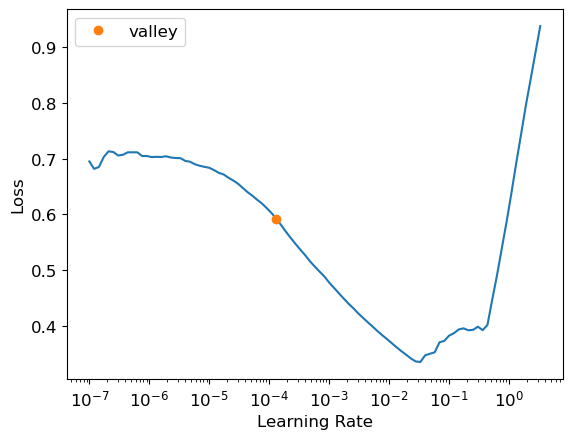

In [119]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()

We'll train with `fit_one_cycle` for a few epochs:

In [120]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.061921,0.067224,00:05
1,0.051130,0.056330,00:04
2,0.046388,0.054012,00:03
3,0.041853,0.054157,00:03
4,0.040173,0.052207,00:03


Let's compare the result to our earlier random forest using the `r_mse` function:

In [121]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.228488

The neural network performs better than the random forest, although it take longer to train and requires more careful hyprerparameter tuning

We'll save our model for future use:

In [122]:
learn.save('nn')

Path('models/nn.pth')

To further improve generalization, we can use ensemble learning, which evolves averaging predictions from several models.

## Ensembling

The success of random forests is rooted in the principle that while individual trees have errors, these errors are not correlated. With enough trees, the average of these errors should approach zero. We can apply similar reasoning to combine predictions from different algorithms.

In our case, we have two distinct models: a random forest and a neural network. Their different approaches likely result in different types of errors. Therefore, averaging their predictions could potentially outperform either model individually.

It's worth nothing that a random forest is itself an ensemble, By combining it with a neural network, we're creating an ensemble of ensembles! While ensembling may not revolutionize your modeling process, it can provide a welcome boost to your exiting model.

One small challenge we face is the different output types from our Pytorch and sklearn models. Pytorch gives a rank-2 tensor (a column matrix), while sklearn produces a rank-1 array (a vector). We can address this using `squeeze` to remove unit axes and `to_np` to convert to Numpy array

In [123]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

This ensemble approach yield better result than either model individually:

In [124]:
r_mse(ens_preds,valid_y)

0.222895

## Boosting


While our previous ensembling approach used bagging (combination many models trained on different data subsets by averaging), another important technique is boosting, where models are added instead of averaged.

Boosting works as follow:

1. Train a small, underfitting model on you dataset.
2. Calculate this model predictions for the training set.
3. Subtract these predictions from the actual targets to get the "residuals"(the error for each training point).
4. Return to step 1, but use the residuals as the new training targets.
5. Repeat this process until reaching a stopping criterion(e.g., maximum number of trees or worsening validation set error).

In this approach, each new tree attempts to fit the combined error of all previous trees. As we continually create new residuals by subtracting each new tree's predictions from the previous residuals, these residuals progressively decrease.

To make predictions with a boosted tree ensemble, we calculate predictions from each tree and sum them. This approach has many variations and names, including Gradient Boosting Machines (GBMs) and Gradient Boosted Decision Trees (GBDTs). XGBoost is currently the most popular implementation.

Unlike random forests, boosting can lead to overfitting. In random forests, adding more trees doesn't cause overfitting because each tree is independent. However, in a boosted ensemble, more trees continuously improve the training error, potentially leading to overfitting on the validation set.

## Key takeaway

We have discussed two approaches to tabular modeling: decision tree ensembles and neural networks. We've also mentioned two different decision tree ensembles: random forests, and gradient boosting machines. Each is very effective, but each also has compromises:

- _Random forests_ are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.
- _Gradient boosting_ machines in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.
- _Neural networks_ take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

We suggest starting your analysis with a random forest. This will give you a strong baseline, and you can be confident that it's a reasonable starting point. You can then use that model for feature selection and partial dependence analysis, to get a better understanding of your data.

From that foundation, you can try neural nets and GBMs, and if they give you significantly better results on your validation set in a reasonable amount of time, you can use them. If decision tree ensembles are working well for you, try adding the embeddings for the categorical variables to the data, and see if that helps your decision trees learn better.

Alright guys, it's been a long post huh? Thanks for reading all of those, catch you on the flip side, and I'll see you... next time!